<a href="https://colab.research.google.com/github/ollihansen90/Mathe-SH/blob/main/Woche_der_KI_Quickdraw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -nc -q https://github.com/ollihansen90/Mathe-SH/raw/main/MINT_Kulturen_2023/model.pth
!wget -nc -q https://github.com/ollihansen90/Mathe-SH/raw/main/MINT_Kulturen_2023/utils.py

import torch
import matplotlib.pyplot as plt
from utils import CNN

device = "cuda" if torch.cuda.is_available() else "cpu"
labelnames = [
            "Schmetterling",
            "Kamera",
            "Becher",
            "Ente",
            "Maus",
            "Eule",
            "Ananas",
            "Schildkröte",
            "Schaf",
            "Schneemann",
            "Sonne",
            "Schwan",
            "Regenschirm",
            ]
model = CNN()
model.load_state_dict(torch.load("model.pth", map_location=device))

<All keys matched successfully>

### Helpers

In [ ]:
def make_prediction_canvas(canvas_size, prediction_func_name):
    canvas_html = f'''
<div>
  <p>Leinwand:</p>
  <canvas id="canvas" width="{canvas_size[0]}" height="{canvas_size[1]}" style="border:5px solid black; touch-action:none; -webkit-user-select:none; -webkit-touch-callout:none;"></canvas>
  <button onclick="predict()">Motiv erkennen</button>
  <button onclick="clear_canvas()">Leinwand zurücksetzen</button>
  <p id="predictionfield">Erkanntes Motiv:</p>
</div>

<script type="text/javascript">
(function() {{
  let originalOverflow = document.body.style.overflow;

  function disableScroll() {{
    originalOverflow = document.body.style.overflow;
    document.body.style.overflow = 'hidden';
  }}
  function enableScroll() {{
    document.body.style.overflow = originalOverflow;
  }}

  function prediction_callback(data) {{
    if (data.msg_type === 'execute_result') {{
        document.getElementById("predictionfield").innerHTML = "Prediction: " + data.content.data['text/plain'];
    }}
  }}

  function predict() {{
    var imgData = ctx.getImageData(0, 0, ctx.canvas.width, ctx.canvas.height);
    imgData = Array.prototype.slice.call(imgData.data).filter((d,i) => i % 4 == 3);
    var kernelAPI = undefined;
    try {{ if (IPython) kernelAPI = "IPython"; }} catch(e){{}}
    try {{ if (google) kernelAPI = "google"; }} catch(e){{}}
    if (kernelAPI === "IPython") {{
        var command = "{prediction_func_name}(" + JSON.stringify(imgData) + ")";
        document.getElementById("predictionfield").innerHTML = "Prediction: calculating...";
        IPython.notebook.kernel.execute(command, {{iopub: {{output: prediction_callback}}}}, {{silent:false}});
    }} else if (kernelAPI === "google") {{
        google.colab.kernel.invokeFunction("{prediction_func_name}", [imgData], {{}}).then(result => {{
            prediction_callback({{msg_type:'execute_result', content:{{data: result.data}}}});
        }});
    }} else {{
        console.error('no kernel api found to invoke predictions!');
    }}
  }}

  var canvas = document.getElementById('canvas');
  var ctx = canvas.getContext('2d');
  var clickX = [], clickY = [], clickDrag = [];
  var drawing = false;

  function addPoint(x, y, dragging) {{
    clickX.push(x);
    clickY.push(y);
    clickDrag.push(dragging);
  }}

  function getLocalPos(evt) {{
    var rect = canvas.getBoundingClientRect();
    return {{ x: evt.clientX - rect.left, y: evt.clientY - rect.top }};
  }}

  if (window.PointerEvent) {{
    canvas.addEventListener('pointerdown', e => {{
      if (!e.isPrimary) return;
      e.preventDefault();
      disableScroll();
      canvas.setPointerCapture(e.pointerId);
      drawing = true;
      var p = getLocalPos(e);
      addPoint(p.x, p.y, false);
      redraw();
    }});

    canvas.addEventListener('pointermove', e => {{
      if (!drawing || !e.isPrimary) return;
      e.preventDefault();
      var p = getLocalPos(e);
      addPoint(p.x, p.y, true);
      redraw();
    }});

    function stopDraw(e) {{
      if (!e.isPrimary) return;
      e.preventDefault();
      enableScroll();
      try {{ canvas.releasePointerCapture(e.pointerId); }} catch(err){{}}
      drawing = false;
    }}
    canvas.addEventListener('pointerup', stopDraw);
    canvas.addEventListener('pointercancel', stopDraw);
  }} else {{
    canvas.addEventListener('touchstart', e => {{
      e.preventDefault();
      disableScroll();
      if (e.touches.length > 1) return;
      var t = e.touches[0];
      var rect = canvas.getBoundingClientRect();
      addPoint(t.clientX - rect.left, t.clientY - rect.top, false);
      drawing = true;
      redraw();
    }}, {{ passive: false }});

    canvas.addEventListener('touchmove', e => {{
      e.preventDefault();
      if (!drawing) return;
      var t = e.touches[0];
      var rect = canvas.getBoundingClientRect();
      addPoint(t.clientX - rect.left, t.clientY - rect.top, true);
      redraw();
    }}, {{ passive: false }});

    canvas.addEventListener('touchend', e => {{
      e.preventDefault();
      drawing = false;
      enableScroll();
    }}, {{ passive: false }});

    canvas.addEventListener('mousedown', e => {{
      e.preventDefault();
      disableScroll();
      drawing = true;
      var p = getLocalPos(e);
      addPoint(p.x, p.y, false);
      redraw();
    }});
    canvas.addEventListener('mousemove', e => {{
      if (!drawing) return;
      e.preventDefault();
      var p = getLocalPos(e);
      addPoint(p.x, p.y, true);
      redraw();
    }});
    canvas.addEventListener('mouseup', e => {{
      drawing = false;
      enableScroll();
    }});
    canvas.addEventListener('mouseleave', e => {{
      drawing = false;
      enableScroll();
    }});
  }}

  window.clear_canvas = function() {{
    clickX = []; clickY = []; clickDrag = [];
    redraw();
    document.getElementById('predictionfield').innerHTML = 'Prediction:';
  }};
  window.predict = predict;

  function redraw() {{
    ctx.clearRect(0, 0, canvas.width, canvas.height);
    ctx.strokeStyle = '#000';
    ctx.lineJoin = 'round';
    ctx.lineWidth = 10;
    for (let i = 0; i < clickX.length; i++) {{
      ctx.beginPath();
      if (clickDrag[i] && i) {{
        ctx.moveTo(clickX[i-1], clickY[i-1]);
      }} else {{
        ctx.moveTo(clickX[i]-1, clickY[i]);
      }}
      ctx.lineTo(clickX[i], clickY[i]);
      ctx.closePath();
      ctx.stroke();
    }}
  }}
}})();
</script>
'''
    display(HTML(canvas_html))

## Zeichnen

In [ ]:
import numpy as np
import torch
import sys
from PIL import Image
from time import time
from IPython.core.display import display, HTML

canvas_size = (280, 280)

def predict_func(img_data):
    #transform the list into a 2d array
    img_data = np.asarray(img_data, dtype=np.float32).reshape(*canvas_size)
    #transform the numpy array into a torch tensor
    x = torch.tensor(img_data, dtype=torch.float).to(device)
    x /= 255
    #move it to the GPU is possible
    #scale it down from 280x280 to 28x28 pixels using bilinear interpolation
    x = torch.nn.functional.interpolate(x.unsqueeze_(dim=0).unsqueeze_(dim=1), size=(28, 28), mode='bilinear', align_corners=True).squeeze_(dim=1).squeeze_(dim=0)
    #add a batch dimension with batch_size=1
    x.unsqueeze_(dim=0)
    #add a color dimension with color channel count=1
    x.unsqueeze_(dim=1)
    x[x>0.5] = 1
    x[x<=0.5] = 0
    #switch model to evaluation mode (only necessary for some modules like dropout and batch normalization, but better to always have it rather than forget it when needed)
    model.eval()
    #predict the label for the input
    global out
    with torch.no_grad():#we don't want to store information for gradient computation
        out = model(x)
    #get the most likely label
    pred_label = out.argmax(1)
    pred_label = pred_label.item()
    #return the predicted class name to the HTML-framework (to be displayed below)
    return labelnames[pred_label]

#create the prediction canvas and make it use the prediction function defined above
if 'google.colab' in sys.modules:
    from google.colab import output
    output.register_callback('predict_func', predict_func)
make_prediction_canvas(canvas_size, "predict_func")

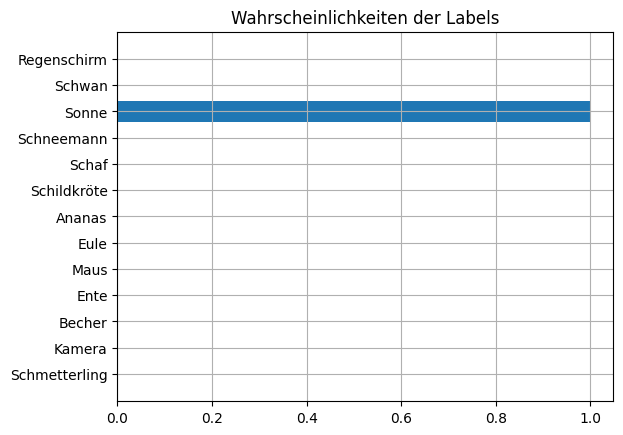

0.9990373849868774


In [ ]:
plt.figure()
plt.barh(labelnames, torch.nn.functional.softmax(out, dim=-1).squeeze().detach().cpu().numpy())
plt.grid()
plt.title("Wahrscheinlichkeiten der Labels")
plt.show()
print(torch.max(torch.nn.functional.softmax(out, dim=-1)).item())

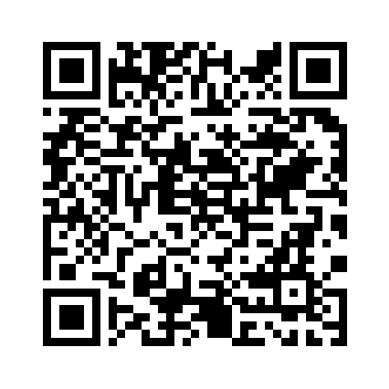

In [ ]:
!pip install qrcode
import qrcode
img = qrcode.make('https://colab.research.google.com/drive/1PhQKVEsGrQqSqwcTuhevIhDI7UNE34Uq')
plt.figure()
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()